# Modelos: Deep Factorization Machine (DeepFM)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
BASE_PATH           = '../..'
LIB_PATH            = f'{BASE_PATH}/lib'
DATASET_PATH        = f'{BASE_PATH}/datasets'
STACKING_PATH       = f'{DATASET_PATH}/stacking'
WEIGHTS_PATH        = f'{BASE_PATH}/weights'

METRICS_PATH        = f'{BASE_PATH}/metrics/deep_fm'
STACKING_TRAIN_PATH = f'{STACKING_PATH}/deep_fm_train.json'
STACKING_TEST_PATH  = f'{STACKING_PATH}/deep_fm_test.json'

In [3]:
import sys
sys.path.append(LIB_PATH)

import numpy as np
import pandas as pd
from bunch import Bunch

import torch
from torch.utils.data import DataLoader, Subset
from torch.optim import Adam
from sklearn.metrics import roc_auc_score

import pytorch_common.util as pu
from pytorch_common.modules.fn import Fn
from pytorch_common.callbacks import EarlyStop, \
                                     ReduceLROnPlateau, \
                                     Validation, \
                                     SaveBestModel
from pytorch_common.callbacks.output import Logger, \
                                            MetricsPlotter

from pytorch_common.util import set_device_name, \
                                get_device, \
                                LoggerBuilder

import model as ml
import data.dataset as ds

import metric as mt
import metric.discretizer as dr

import data.plot as pl
import data as dt

import logging
import random

import util as ut

2023-04-16 13:54:33.212390: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-16 13:54:33.703470: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-04-16 13:54:34.000714: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-16 13:54:34.000949: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA n

<Figure size 640x480 with 0 Axes>

## Setup

In [4]:
ut.mkdir(STACKING_PATH)

In [5]:
pu.LoggerBuilder().on_console().build()

<RootLogger root (INFO)>

In [6]:
import pytorch_common
pytorch_common.__version__

'0.1.2'

In [7]:
torch.__version__

'1.11.0'

In [8]:
pu.set_device_name('gpu')

pu.get_device(), torch.cuda.is_available()

(device(type='cuda', index=0), True)

In [9]:
ut.set_seed(42)

In [10]:
TRAIN = True

In [11]:
def get_stacking_df(model, ds, dl):
    predictions = model.evaluate(dl)
    return pd.DataFrame({
        'user_id'	 : ds.data['user_id'],
        'movie_id'   : ds.data['movie_id'],
        'rating'     : predictions[1].flatten().numpy(),
        'prediction' : predictions[0].numpy()
    })

In [12]:
def to_dl(train_set, eval_set, test_set, params):
    train_dl = DataLoader(train_set, params.batch_size, num_workers=params.n_workers, pin_memory=True, shuffle = True)
    eval_dl  = DataLoader(eval_set,  params.batch_size, num_workers=params.n_workers, pin_memory=True)
    test_dl  = DataLoader(test_set,  params.batch_size, num_workers=params.n_workers, pin_memory=True)
    return train_dl, eval_dl, test_dl

In [13]:
def to_tensor(obs, device, columns): 
    data = obs[columns]
    if type(data) == pd.DataFrame:
        data = data.values
    return torch.tensor(data).to(device)

features_fn = lambda obs, device: to_tensor(obs, device, ['user_seq', 'movie_seq'])
target_fn   = lambda obs, device: to_tensor(obs, device, ['user_movie_rating'])

## Carga de dataset

In [14]:
dataset = ds.MovieLensTMDBDatasetFactory.from_path(
    path             = DATASET_PATH,
    transform        = features_fn,
    target_transform = target_fn,
    device           = torch.device('cpu'),
    filter_fn        = lambda df: df[(df['user_movie_rating_year'] >= 2004)]
)

train_set, eval_test_set, rating_mean_df, rating_std = dataset.train_test_split(split_year=2016)

eval_set, test_set, _, _ = eval_test_set.train_test_split(
    split_year     = 2018, 
    rating_mean_df = rating_mean_df, 
    rating_std     = rating_std
)

train_set.shape, eval_set.shape, test_set.shape

2023-04-16 13:54:36,645 - INFO - Train: 63.88 % - Test: 9.88 %
2023-04-16 13:54:36,721 - INFO - Train: 55.65 % - Test: 28.94 %


((99934, 18), (8606, 18), (4475, 18))

## Definicion del modelo

In [15]:
params = Bunch({
    'lr'                : 0.001,
    'lr_factor'         : 0.1,
    'lr_patience'       : 8,
    'epochs'            : 10,
    'embedding_size'    : 50,
    'units_per_layer'   : [20, 1],
    'dropout'           : 0.1,
    'n_workers'         : 24,
    'batch_size'        : 64,
    'features_n_values' : [len(it) for it in dataset.features_uniques]
})

In [20]:
model = ml.DeepFM(
    params.features_n_values,
    params.embedding_size,
    params.units_per_layer,
    params.dropout
).to(pu.get_device())
model

DeepFM(
  (lineal): CategoricalFeaturesLineal(
    (embedding): MultiFeatureEmbedding(
      (embedding): Embedding(19393, 1)
    )
  )
  (fm): EmbeddingFactorizationMachine()
  (embedding): MultiFeatureEmbedding(
    (embedding): Embedding(19393, 50)
  )
  (mlp): MultiLayerPerceptron(
    (mlp): Sequential(
      (0): Linear(in_features=100, out_features=20, bias=True)
      (1): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.5, inplace=False)
      (4): Linear(in_features=20, out_features=1, bias=True)
    )
  )
  (act): ReLU()
)

## Entrenamiento del modelo

In [17]:
train_dl, eval_dl, test_dl = to_dl(train_set, eval_set, test_set, params)

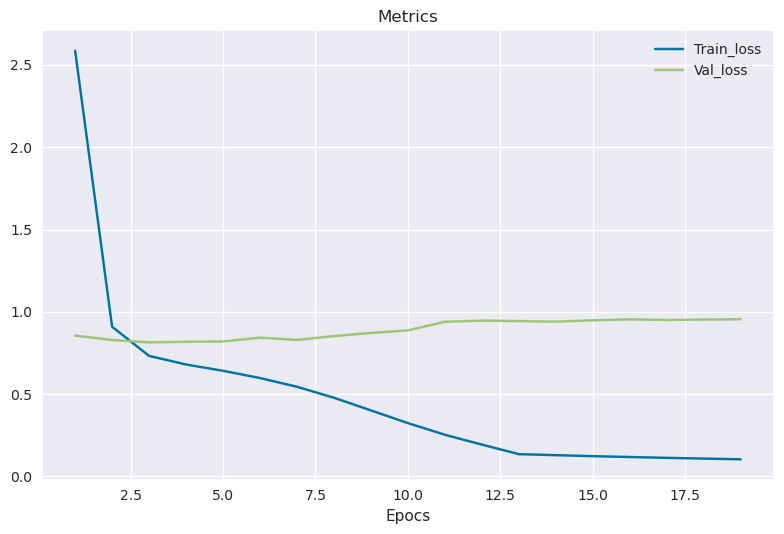

2023-04-16 13:59:11,604 - INFO - {'time': '0:00:06.49', 'epoch': 20, 'train_loss': 0.10065380396934348, 'val_loss': 0.959271252155304, 'lr': 0.0001}


In [21]:
if TRAIN:
    result = model.fit(
        train_dl,
        epochs      = params.epochs,
        loss_fn     = ml.MSELossFn(),
        optimizer   = Adam(
            params       = model.parameters(),
            lr           = params.lr
        ),
        callbacks   = [
            Validation(eval_dl, metrics = { 'val_loss': ml.MSELossFn(float_result=True)}),
            ReduceLROnPlateau(metric='val_loss', mode='min', factor=params.lr_factor, patience=params.lr_patience),
            MetricsPlotter(metrics=['train_loss', 'val_loss'], plot_each_n_epochs=2),
            Logger(['time', 'epoch', 'train_loss', 'val_loss', 'patience', 'lr']),
            SaveBestModel(metric='val_loss', path=WEIGHTS_PATH, experiment_name='deep_fm')
        ]
    )

In [23]:
model.load(f'{WEIGHTS_PATH}/2023-04-16_13-57-19--deep_fm--epoch_3--val_loss_0.8144221901893616')

## Stacking dataset

Se realiza la prediccion del modelo sobre el conjunto de evaluacion, el cual sera el conjunto de entrenamiento para el meta-modelo del stacking.

In [24]:
ut.save_df(get_stacking_df(model, eval_set, eval_dl), STACKING_TRAIN_PATH)
ut.save_df(get_stacking_df(model, test_set, test_dl), STACKING_TEST_PATH)

## Evaluación del modelo

In [25]:
n_classes = len(dataset.target_uniques)

validator = ml.Validator(
    n_samples  = 500,
    batch_size = 10000,
    metrics    = [
        mt.RMSE(),
        mt.MeanNdcgAtk            (k=5),
        mt.MeanAveragePrecisionAtk(k=5, discretizer=dr.between(4, 5)),
        mt.MeanUserFBetaScoreAtk  (k=5, n_classes=n_classes, discretizer=dr.between(4, 5)),
        mt.MeanUserPrecisionAtk   (k=5, n_classes=n_classes, discretizer=dr.between(4, 5)),
        mt.MeanUserRecallAtk      (k=5, n_classes=n_classes, discretizer=dr.between(4, 5))
    ],
    predictors = [ml.ModulePredictor(model)]
)

summary = validator.validate(eval_set)

summary.save(METRICS_PATH)

Processing:   0%|          | 0/500 [00:00<?, ?it/s]

In [26]:
summary = ml.ValidatorSummary.load(METRICS_PATH)
summary.show()

Ordered by mAP@5(4,5):


,sample,RMSE,mNDCG@5,"mAP@5(4,5)","MeanUserF1.0Score@5(4,5)","Precision@5(4,5)","Recall@5(4,5)"
predictor,,,,,,,
DeepFM,249.5,0.902296,0.9574,0.435632,0.652114,0.651728,0.651914


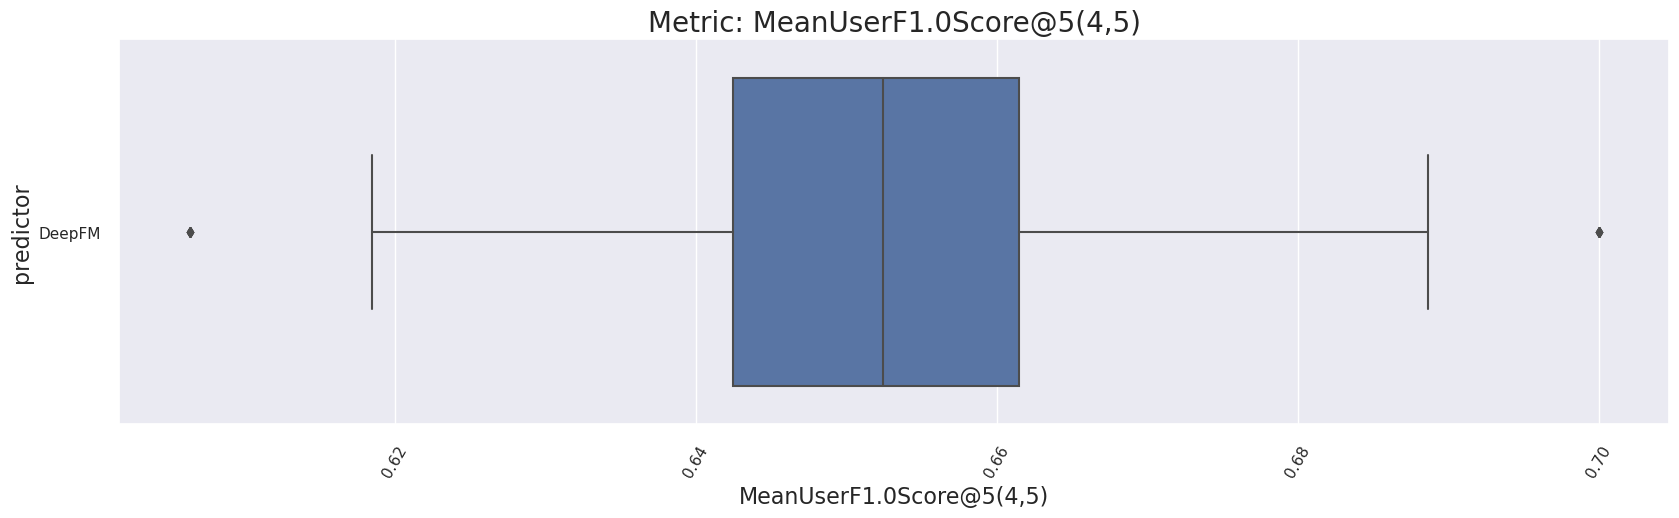

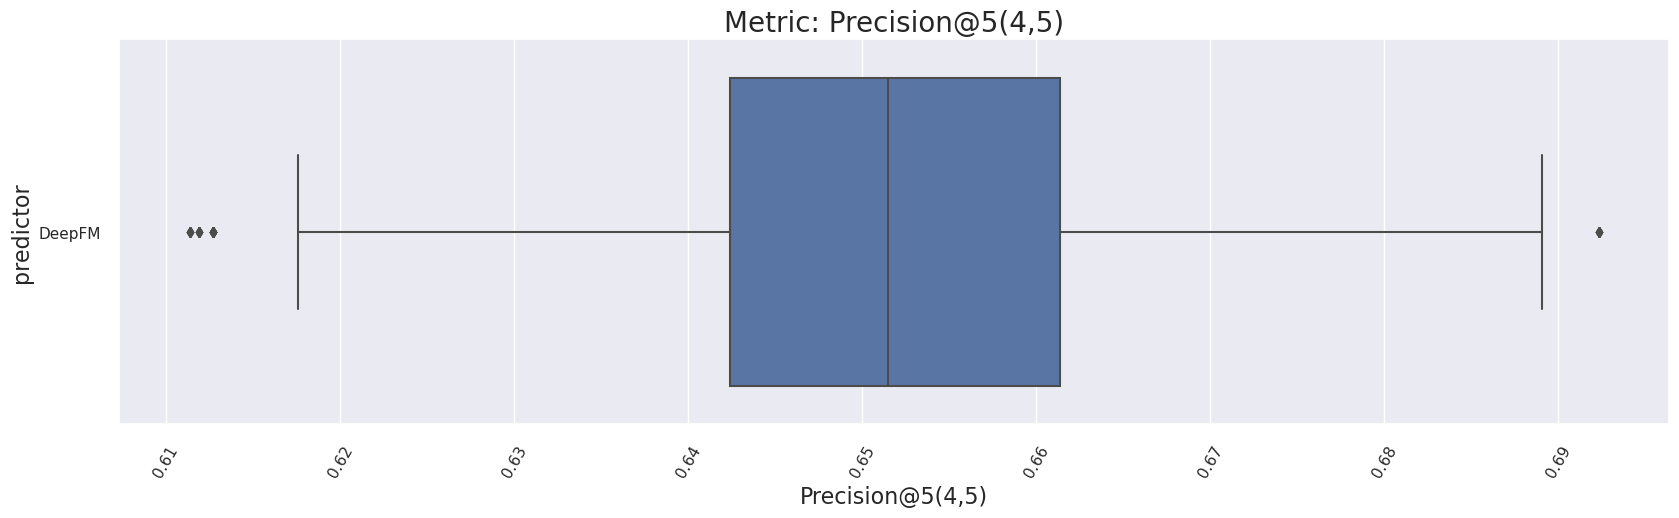

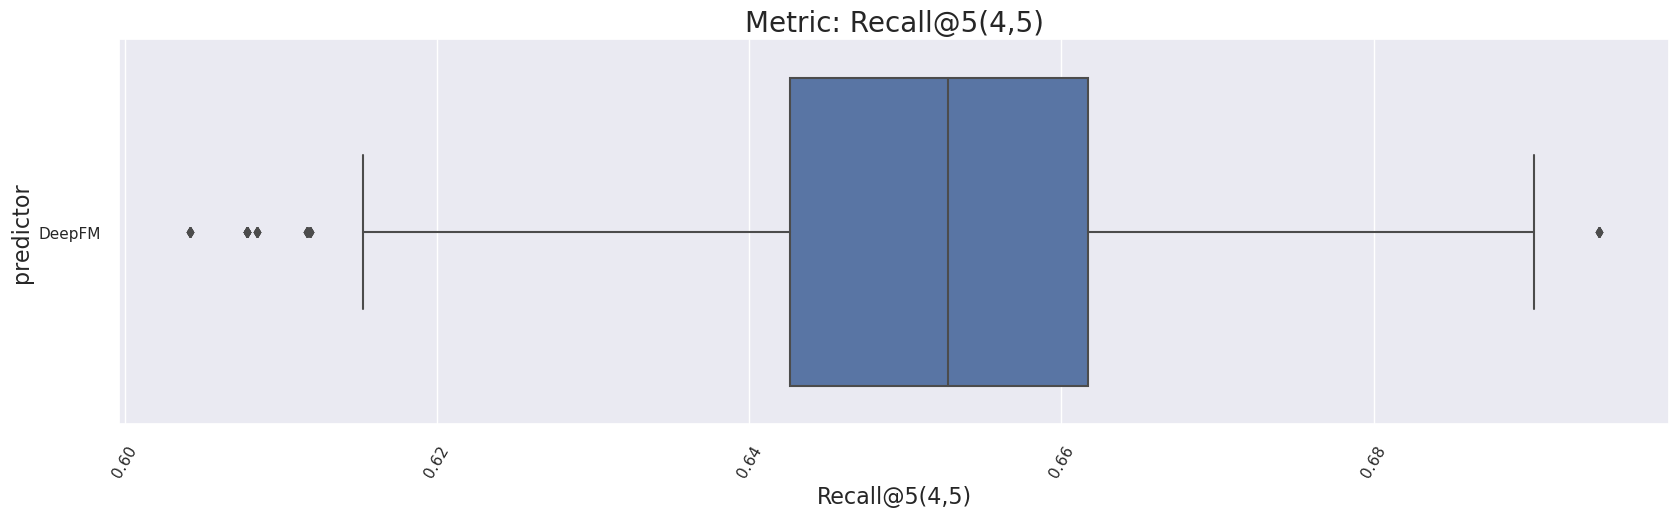

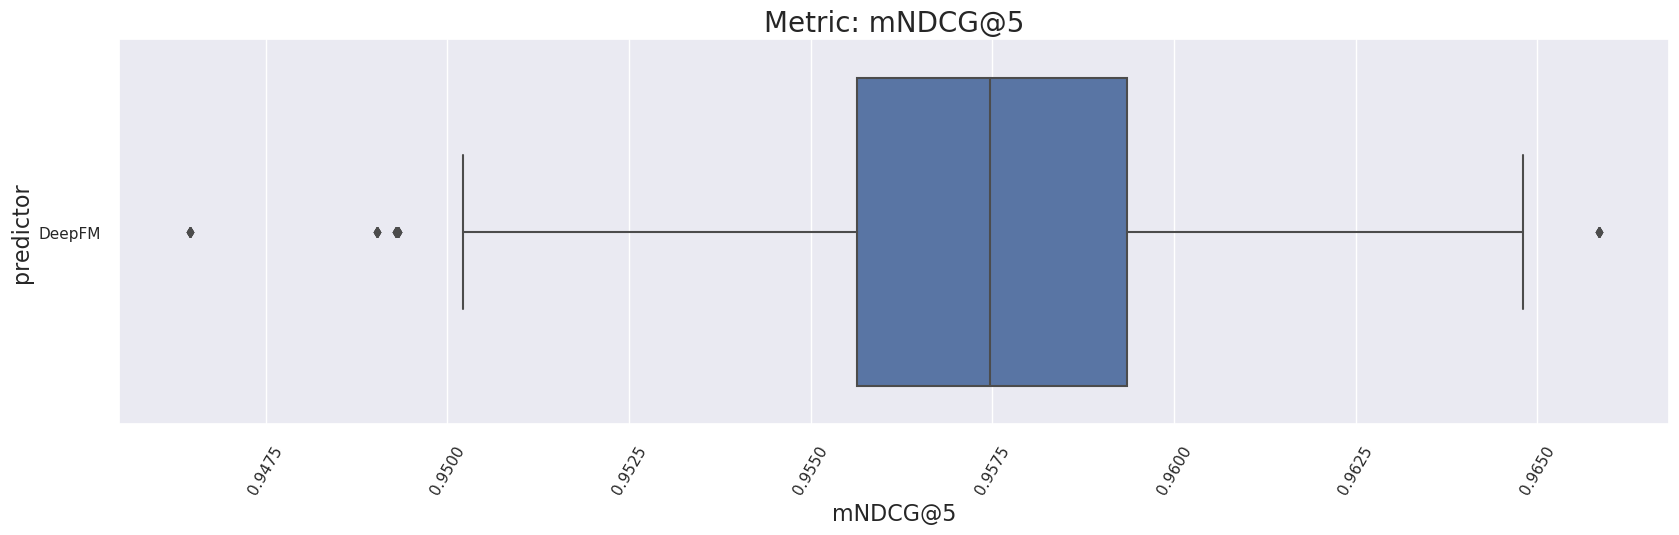

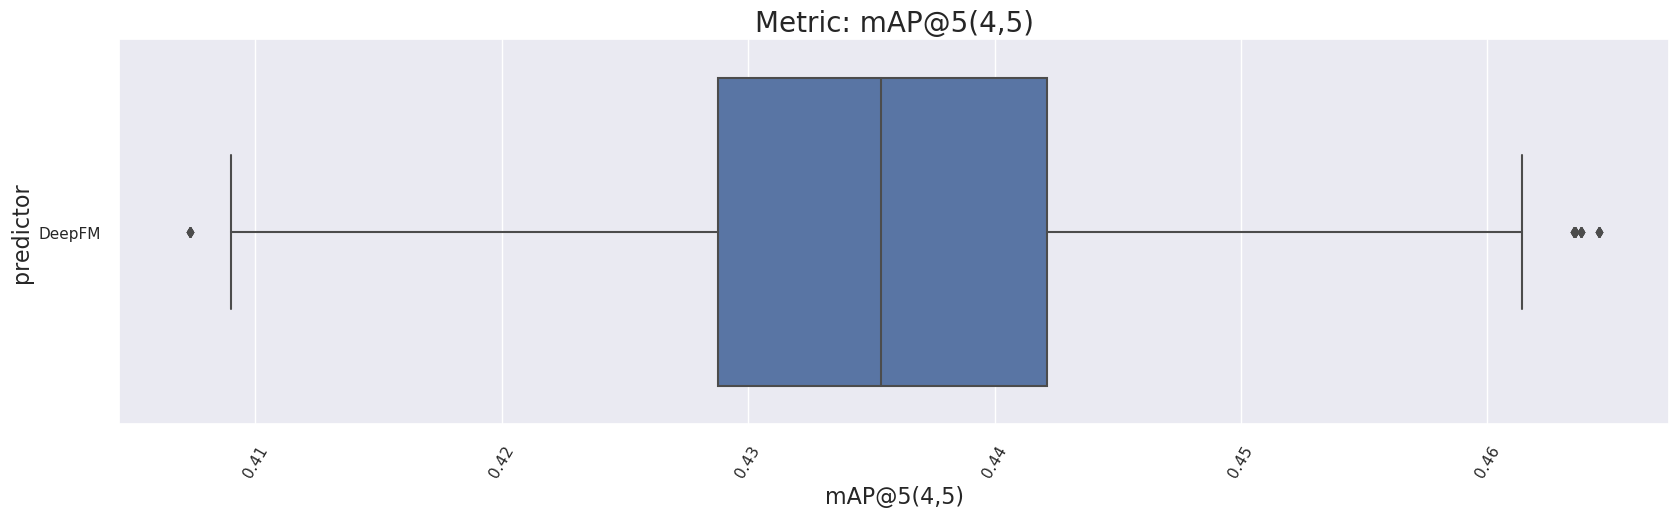

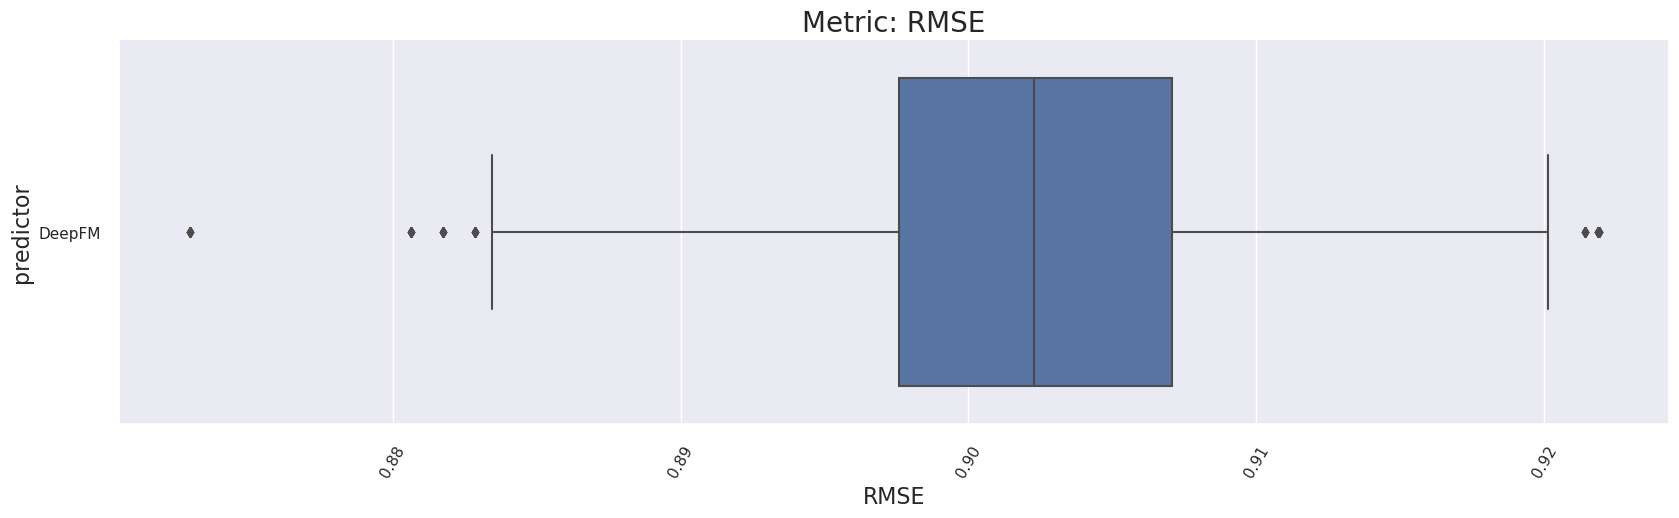

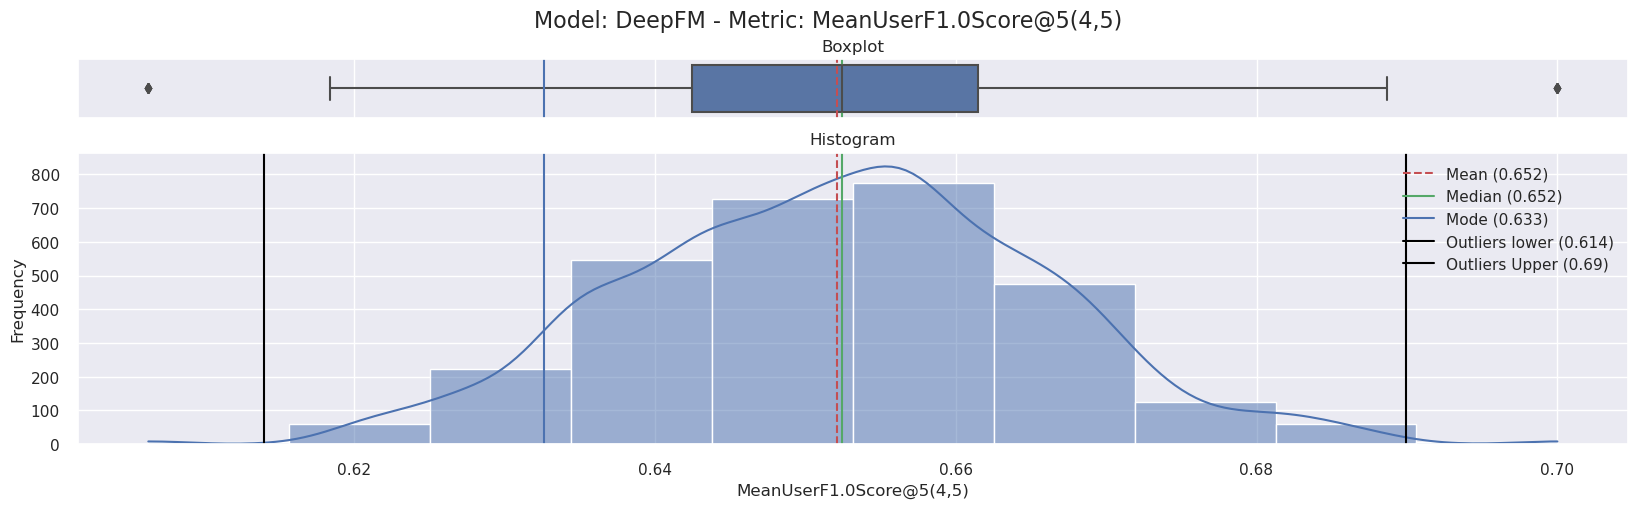

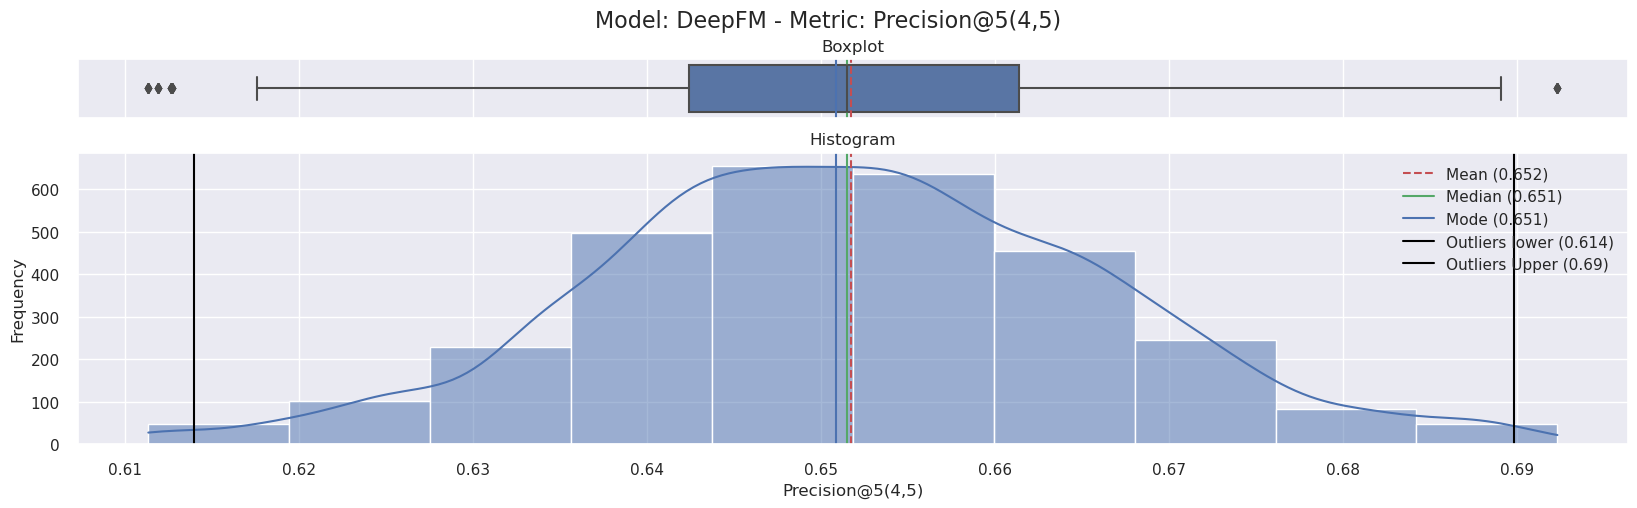

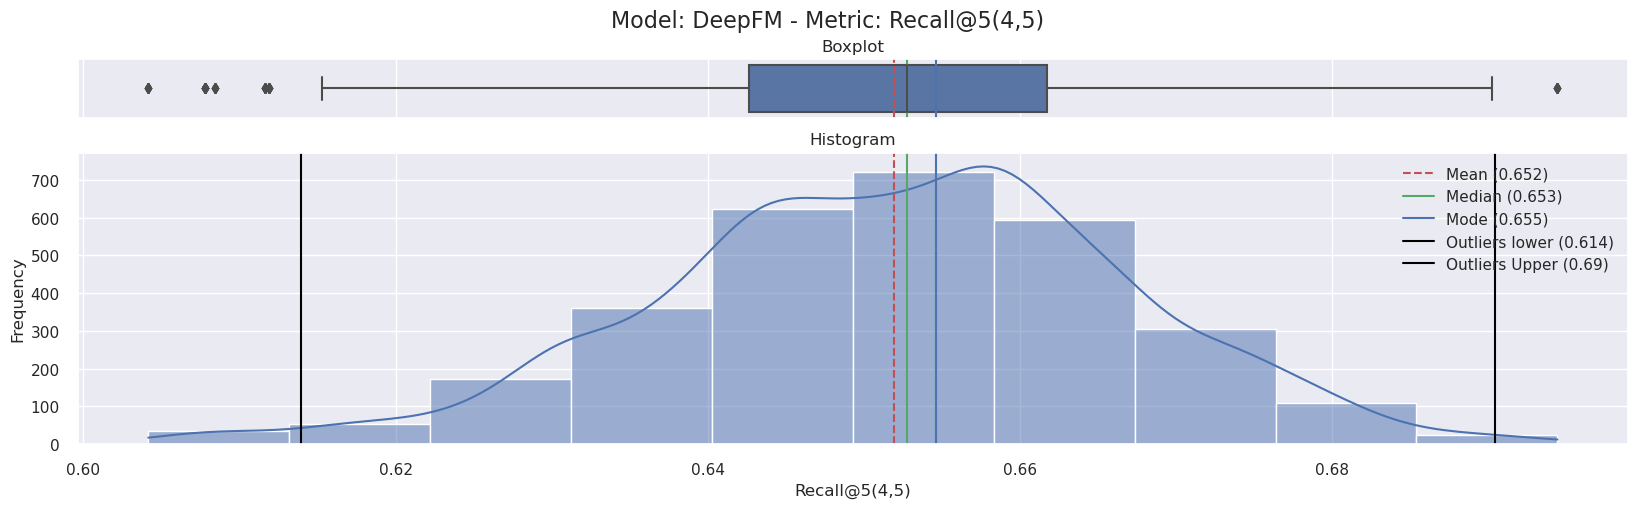

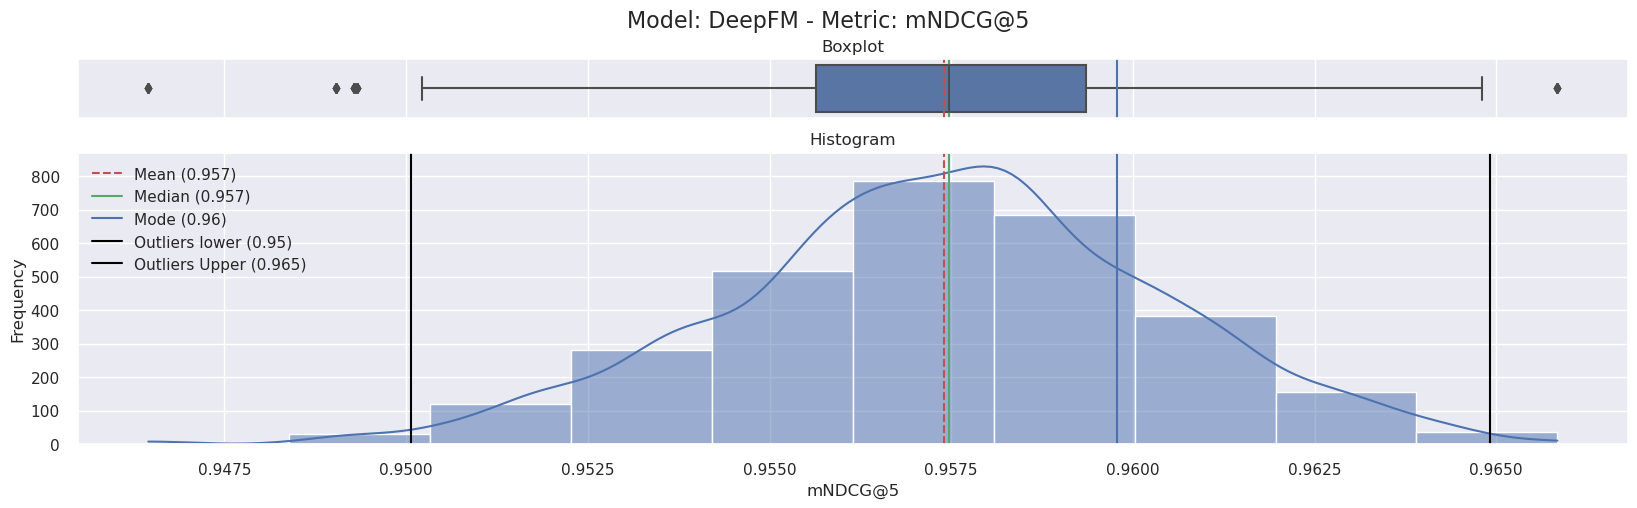

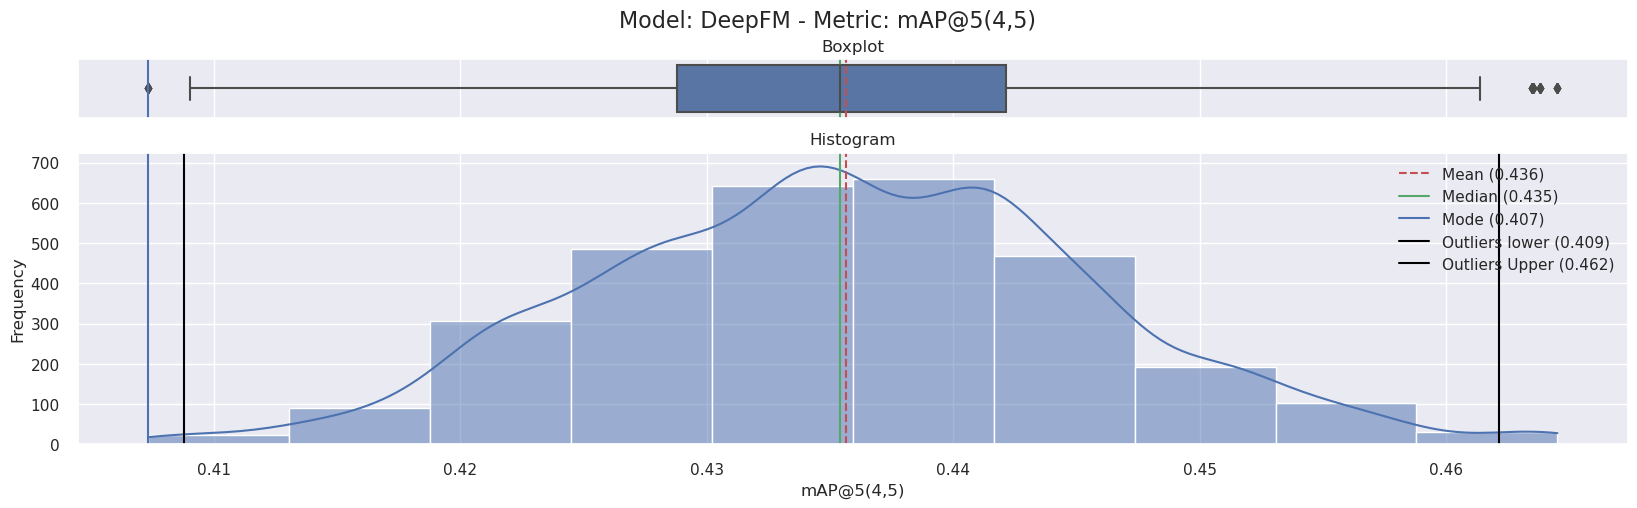

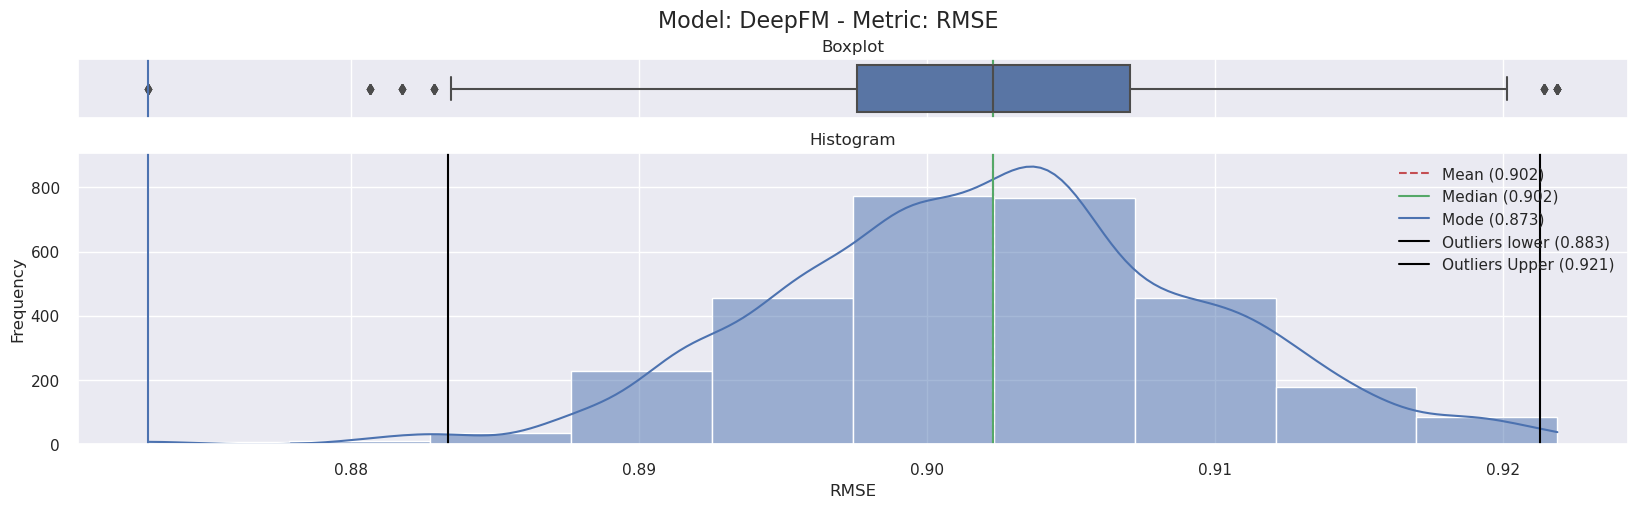

In [27]:
summary.plot(bins=10)